In [1]:
### This notebook gives a tool to draw the gamma gated proton spectra for some given peaks that can be defined in 
### this notebook. This script uses the files singleproton gamma gated protons which means we are only considering
### events which are within the criteria of the single proton spectra.
### More peaks can be either removed or added easily by modifying the loading of files.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob


In [3]:
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
g_singlep_path = "/home/haue/repositories/Masters/data/gamma/Al/singlep_gammas"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"

#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))
g_singlep_files = glob.glob(os.path.join(g_singlep_path, "*mlio.root"))

#Files to be analyzed 
Analysis_files = g_singlep_files


bw = 0.02 # bin width to be used, 10 keV
scale = 3.326542500626603 # difference in solid angle coverage of two proton events up to 4pi

In [4]:
# Define gamma gates and their background regions
peak_gates = {
    "332": [(322, 342), (302, 322), (342, 362)],
    #"445": [(435,455), (415,435), (455, 475)],
    #"735": [(720,750), (690,720), (750,780)],
    #"840": [(828,848), (808,828), (848, 868)],
    #"950": [(935, 965), (905, 935), (965, 995)],
    #"1070":[(1059, 1079), (1039,1059), (1079,1099)],
    "1113": [(1090,1120), (1060,1090), (1120,1150)],
    "1384": [(1366,1396), (1336,1366), (1396,1426)],
    "1590": [(1580, 1610), (1550,1580), (1550,1580)],
    "1634": [(1620,1650), (1590,1620), (1650,1680)],
    #"1716": [(1705,1735), (1675,1705), (1765,1795)],
    #"1745": [(1735,1765), (1675,1705), (1765,1795)],
    #"2497": [(2480,2510), (2450,2480), (2510,2540)],
    #"2830": [(2810,2840), (2780,2810), (2840,2870)],

    # can add more gates...
}
# Initialize storage for results
gprotons = {}
region_labels = ["gate", "lower_bg", "upper_bg"]

for gate_name, peak_ranges in peak_gates.items():
    Elist_1 = [np.array([]) for _ in peak_ranges]
    Elist_2 = [np.array([]) for _ in peak_ranges]

    for i, (low, high) in enumerate(peak_ranges):
        
        for batch in uproot.iterate(Analysis_files, expressions=["E"],
            cut=f"(pg1) & (Eg1>{low}) & (Eg1<{high})"):
            Elist_1[i] = np.append(Elist_1[i], ak.flatten(batch.E))

        for batch in uproot.iterate(Analysis_files, expressions=["E"],
            cut=f"(pg2) & (Eg2>{low}) & (Eg2<{high})"):
            Elist_2[i] = np.append(Elist_2[i], ak.flatten(batch.E))

    # Clean and combine
    Elist_1 = [arr[~np.isnan(arr)] for arr in Elist_1]
    Elist_2 = [arr[~np.isnan(arr)] for arr in Elist_2]
    Elist = [np.concatenate((a1, a2)) for a1, a2 in zip(Elist_1, Elist_2)]

    # Store in dictionary with semantic labels
    gprotons[gate_name] = {
        region_labels[i]: Elist[i] for i in range(len(region_labels))
    }
    print(f"Gate: {gate_name} processed succesfully!")

Gate: 332 processed succesfully!
Gate: 1113 processed succesfully!
Gate: 1384 processed succesfully!
Gate: 1590 processed succesfully!
Gate: 1634 processed succesfully!


In [5]:
### Single proton spectra
#E = np.array([])
#for batch in uproot.iterate(Al_files, expressions=["E"],
#                            cut="(id<4) & (id>0)"):
#    E=np.append(E, ak.flatten(batch.E))

E2 = np.array([])
for batch in uproot.iterate(Al_files, expressions=["E"],
                            cut="(id>0) & (id<4)"):
    E2=np.append(E2, ak.flatten(batch.E))
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id>0) & (id<4)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
bins = np.arange(250, 9000+10, 10)
counts_E2, _ = np.histogram(E2, bins=bins)
counts_E2p, _ = np.histogram(E2p, bins=bins)

Es = counts_E2 - scale * counts_E2p
Es = np.maximum(Es, 0) 
E = np.repeat((bins[:-1] + 0.5 * (bins[1] - bins[0])),np.asarray(Es).astype(int))

In [6]:
plt.rcParams["xtick.top"] = True    # enable top x-ticks
plt.rcParams["ytick.right"] = True  # enable right y-ticks
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

Elin = np.arange(0., 11000., 10.)
sac = np.array([])
curdir = os.getcwd()
os.chdir("/home/haue/repositories/Masters/analysis/python/twoproton")
for dssd, ssd, cutoff, thresh in zip(
    ["U1", "U2", "U3", "U4", "U6"], ["P1", "P2", "P3", "P4", "P6"], [600, 500, 260, 1000, 300], [280, 340, 180, 350, 220]): # P6 thresh: 220
    filename = "sam_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["SAM", "-i45", "-d%s" % dssd], cwd="/home/haue/repositories/Masters/setup", stdout=f)
        f.close()
    sr = np.loadtxt(filename)
    #im = plt.imshow(100*np.transpose(sr)/(4*np.pi), extent=[0.5, 16.5, 16.5, 0.5], vmin=0., cmap=plt.cm.inferno)
    #cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    #plt.show()
    
    filename = "tdz_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["TDZ", "-d%s,%s" % (dssd, ssd), "-i45", "--threshold=%s" % str(thresh)], cwd="/home/haue/repositories/Masters/setup/", stdout=f)
        f.close()
    
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt(filename, unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < cutoff:
#             print(Elin[i])
            sac = np.append(sac, val)
        else:
            # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
#                         print(j, k, Elin[i])
                        pass
                    else:
                        val += sr[j, k]
            sac = np.append(sac, val)
            
os.chdir(curdir)     
sac_ = 100*sac/(4*np.pi)
sac1 = sac_[0:len(Elin)]
sac2 = sac_[len(Elin):2*len(Elin)]
sac3 = sac_[2*len(Elin):3*len(Elin)]
sac4 = sac_[3*len(Elin):4*len(Elin)]
sac6 = sac_[4*len(Elin):5*len(Elin)]
#plt.figure(figsize=(12,4))
#plt.plot(Elin/1e3, sac1, 'k-', label='U1-P1')
#plt.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
#plt.plot(Elin/1e3, sac3, 'k:', label='U3-P3')
#plt.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
#plt.plot(Elin/1e3, sac6, 'k-.', label='U6-P6')

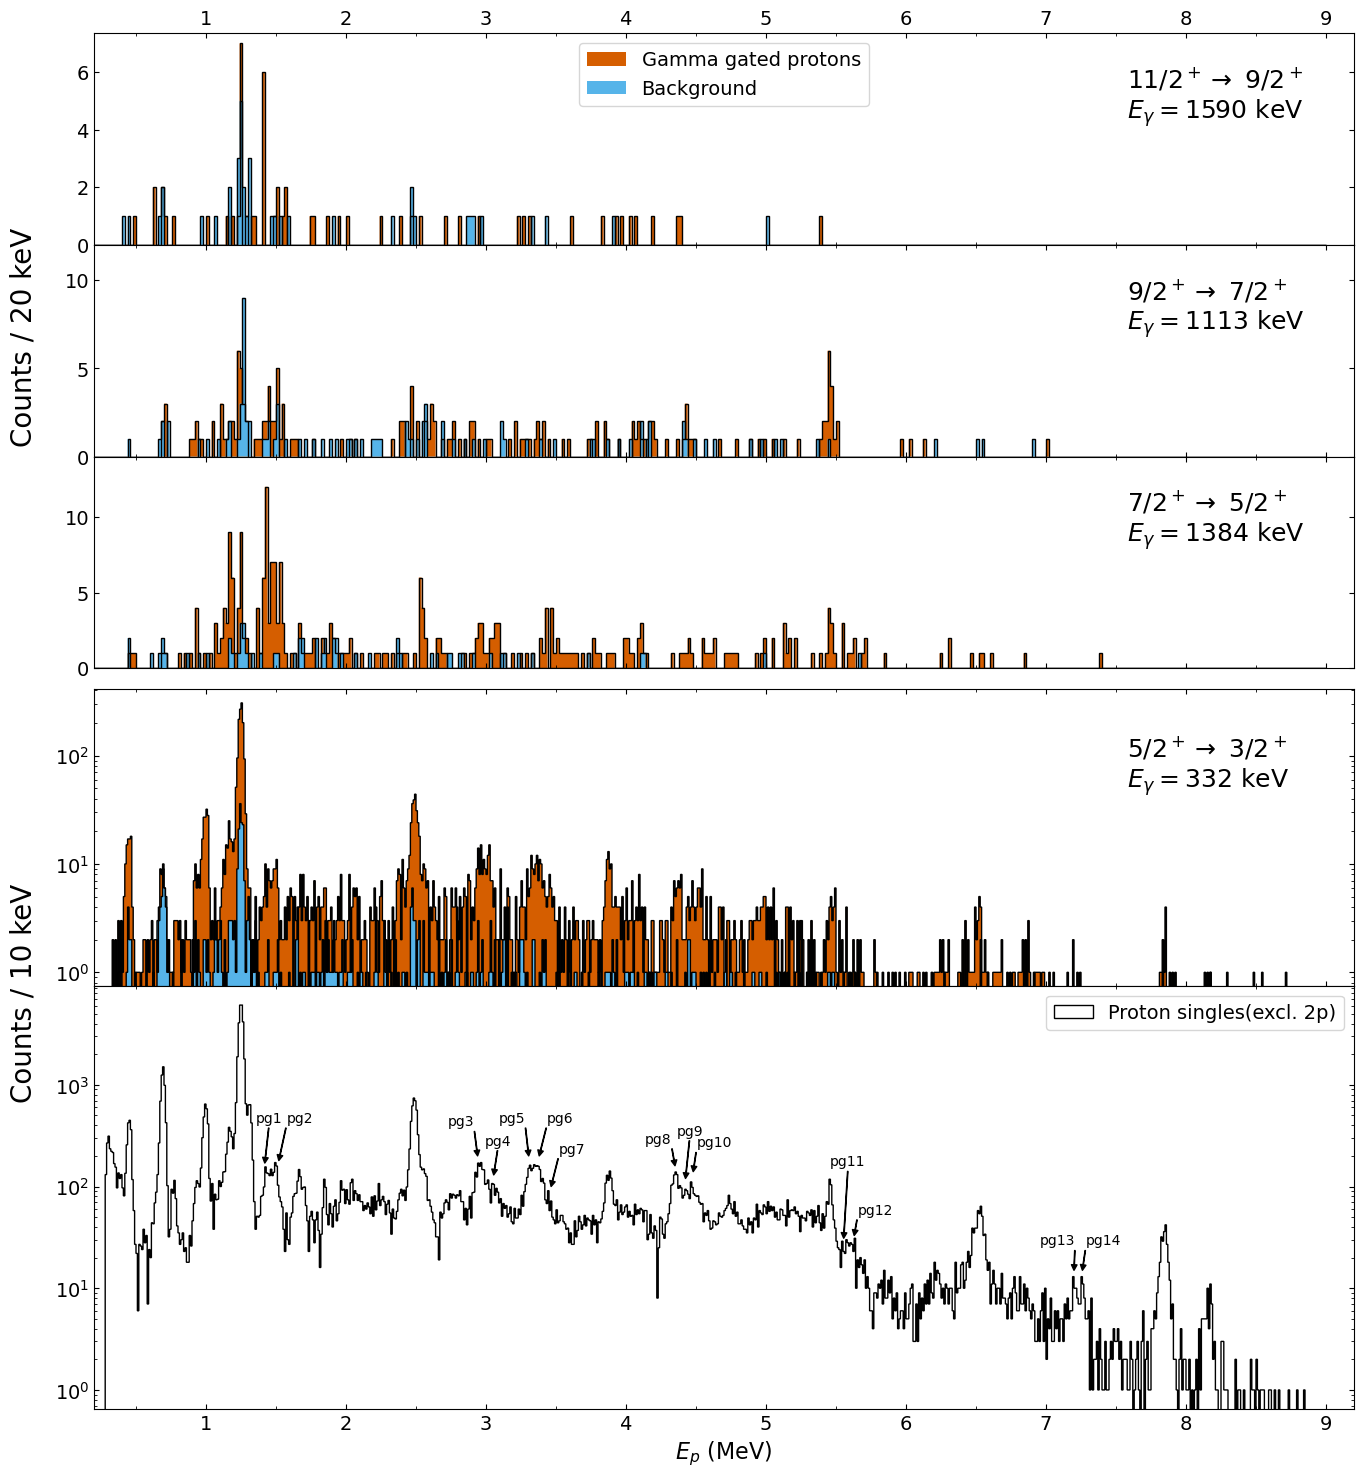

In [29]:
fs = 14
fs_ticks = 12

fig = plt.figure(figsize=(14, 16))
gs = fig.add_gridspec(
    nrows=6, ncols=1,
    height_ratios=[0.5, 0.5, 0.5, 0.05, 0.7, 1],
    hspace=0.0
)
plt.subplots_adjust(top=0.92, bottom=0.06, left=0.08, right=0.98)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
ax2 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax3 = fig.add_subplot(gs[4, 0], sharex=ax0)
ax4 = fig.add_subplot(gs[5, 0], sharex=ax0)

ax0.hist(gprotons[f"1590"]["gate"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='stepfilled', color='#D55E00', edgecolor='none', label="Gamma gated protons")#label=r"1590 $\gamma$ gated protons")
ax0.hist(gprotons[f"1590"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='stepfilled', color='#56B4E9', edgecolor='none', label="Background")
ax0.hist(gprotons[f"1590"]["gate"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='step', color='k')
ax0.hist(gprotons[f"1590"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='step', color='k')
ax0.set_yscale('linear')

ax1.hist(gprotons[f"1113"]["gate"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='stepfilled', color='#D55E00', edgecolor='none', label=r"1113 $\gamma$ gated protons")
ax1.hist(gprotons[f"1113"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='stepfilled', color='#56B4E9', edgecolor='none', label="Background")
ax1.hist(gprotons[f"1113"]["gate"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='step', color='k')
ax1.hist(gprotons[f"1113"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='step', color='k')
ax1.set_yscale('linear')

ax2.hist(gprotons[f"1384"]["gate"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='stepfilled', color='#D55E00', edgecolor='none', label=r"1384 $\gamma$ gated protons")
ax2.hist(gprotons[f"1384"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='stepfilled', color='#56B4E9', edgecolor='none', label="Background")
ax2.hist(gprotons[f"1384"]["gate"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='step', color='k')
ax2.hist(gprotons[f"1384"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.02, 0.02),
         histtype='step', color='k')
ax2.set_yscale('linear')

ax3.hist(gprotons[f"332"]["gate"]/1e3, bins=np.arange(0, 9+0.01, 0.01),
         histtype='stepfilled', color='#D55E00', edgecolor='none', label=r"332 $\gamma$ gated protons")
ax3.hist(gprotons[f"332"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.01, 0.01),
         histtype='stepfilled', color='#56B4E9', edgecolor='none', label="Background")
ax3.hist(gprotons[f"332"]["gate"]/1e3, bins=np.arange(0, 9+0.01, 0.01),
         histtype='step', color='k')
ax3.hist(gprotons[f"332"]["upper_bg"]/1e3, bins=np.arange(0, 9+0.01, 0.01),
         histtype='step', color='k')
ax3.set_yscale('log')

ax4.hist(E/1e3, bins=np.arange(0, 9+0.01, 0.01),
         histtype='step', color='k', label="Proton singles(excl. 2p)")
ax4.set_yscale('log')
ax4.legend(fontsize=fs, loc='upper right')

txts = [("11/2", "9/2"), ("9/2","7/2"),("7/2","5/2"),("5/2","3/2")]#[r"$11/2^+ \ \rightarrow \ 9/2^+", r"$9/2^+ \ \rightarrow \ 7/2^+",r"$7/2^+ \ \rightarrow \ 5/2^+",r"$5/2^+ \ \rightarrow \ 3/2^+"] 
g_energies = ["1590", "1113", "1384", "332"]

for ax,t,g in zip([ax0, ax1, ax2, ax3],txts,g_energies):
    ax.tick_params(axis='x', which='both', labelbottom=False)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    #ax.legend(title=rf"${t[0]}^+ \rightarrow \ {t[1]}^+$", loc='upper right', fontsize=fs, title_fontsize=fs)
    textstr = rf"${t[0]}^+ \rightarrow \ {t[1]}^+$" + "\n" + rf"$E_\gamma = {g}$ keV"
    ax.text(0.82, 0.85, textstr, transform=ax.transAxes,
            fontsize=fs+4, va='top', ha='left',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8,edgecolor='none'))
ax0.legend(loc='upper center', fontsize=fs)
ax4.tick_params(axis='both', which='major', labelsize=fs)
ax4.tick_params(axis='both', which='minor', labelsize=14)
ax4.tick_params(axis='x', bottom=True, top=False,
                labelbottom=True, labeltop=False,
                labelsize=fs_ticks+2, direction='in')

ax0.tick_params(axis='x', bottom=False, top=True,
                labelbottom=False, labeltop=True,
                labelsize=fs_ticks+2, direction='in')

ax4.set_xlabel(r"$E_p$ (MeV)", fontsize=16)
ax4.set_xticks(np.arange(0.5, 10, 0.5), minor=True)

ax0.set_xlim(0.2, 9.2)
ax1.set_yticks(np.arange(0,15,5))
ax1.set_ylim(0,12)
ax2.set_yticks(np.arange(0,20,5))
ax2.set_ylim(0,14)
fig.text(0.02, 0.73, "Counts / 20 keV", va='center',
         rotation='vertical', fontsize=20)
fig.text(0.02, 0.32, "Counts / 10 keV", va='center',
         rotation='vertical', fontsize=20)


trues = [1425, 1500, 2970, 3055, 3315, 3380,3445, 4350,4425,4470, 5555, 5630, 7200, 7260]
trues_err = [15, 20, 30, 30, 25, 30, 15, 25, 15, 15, 20, 20, 20, 20]
es = [1.42, 1.52,2.940,3.055, 3.305, 3.380,3.465, 4.350, 4.425, 4.48, 5.555, 5.630, 7.2, 7.26]
arrow = [(0.17*1e3,0.4*1e3, "cent"), (0.18*1e3,0.4*1e3, "right"), (2.e2, 3.7e2, "left"), (1.3e2, 2.4e2, "cent")
         , (2.e2, 4e2, "left"), (2.e2, 4e2, "right"),(1.e2, 2.e2, "right"), (1.6e2, 2.5e2, "left"), (1.2e2, 3e2, "cent"),(1.4e2, 2.3e2, "right"),
         (3.1e1, 1.5e2, "cent"), (3.3e1, 5e1, "right"), (1.5e1, 2.5e1, "left"), (1.5e1, 2.5e1, "right")]

i = 1
for e,a in zip(es,arrow):
    if isinstance(a, tuple):
        if a[2] == "left":
            ax4.annotate(f"pg{i}", xy=(e, a[0]), xytext=(e-0.12, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=10, color='k')
        if a[2] == "right":
            ax4.annotate(f"pg{i}", xy=(e, a[0]), xytext=(e+0.15, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=10, color='k')
        if a[2] == "cent":
            ax4.annotate(f"pg{i}", xy=(e, a[0]), xytext=(e+0.03, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4), ha='center', va='bottom', fontsize=10, color='k')
    else:
        ax4.annotate(f"pg{i}", xy=(e, a), ha='center', va='bottom', fontsize=12, color='k')#, xytext=(e, a[1]), arrowprops=dict(facecolor='k', edgecolor='k', width=0.3, headwidth=4, headlength=4))
    i+=1

plt.savefig("gamgates.pdf")
plt.show()
#3445


In [ ]:

def plot_energy_hists(
    energies_list,          # list of arrays of energies (in eV)
    reference_overlay=None, # overlay of comparison spectra
    colors=None,            # list of colors matching energies_list
    labels=None,            # list of labels matching energies_list
    bin_width=0.01,         # bin width in MeV
    over_binw = 0.01,
    scale=None,
    title="Energy Histogram",
    xlabel="Energy (MeV)",
    ylabel="default",
    xlim=(0.25, 8.5),
    fig_ax=None,             # optionally pass existing (fig, ax)
    saveas = None,
    overlay_name = "default",
    maxy = scale,
    yscale = 'log',
):
    """
    Plot one or more energy histograms on the same figure with consistent formatting.

    Parameters:
    - energies_list: list of np.arrays, each containing energies (in eV)
    - colors: list of color strings (same length as energies_list), default black if None
    - labels: list of labels (same length as energies_list), default None (no legend)
    - bin_width: float, bin width in MeV
    - title, xlabel, ylabel: strings for the plot
    - xlim: tuple, x-axis limits
    - fig_ax: tuple (fig, ax) if you want to add to existing plot, else None to create new

    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    bins = np.arange(0, 9 + bin_width, bin_width)
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(16, 7))
    else:
        fig, ax = fig_ax
    
    if colors is None:
        colors = ['k'] * len(energies_list)
    if labels is None:
        labels = [None] * len(energies_list)
    
    for energies, color, label in zip(energies_list, colors, labels):
        ax.hist(np.array(energies) / 1e3, bins=bins, histtype='step',
                edgecolor=color, color='white', lw=1, label=label)
    
    if reference_overlay is not None:
        
        if overlay_name == "default":
            overlay_name = "Proton spectrum" 
        
        overlay_bins = np.arange(0, 9 + over_binw, over_binw)  # fixed 10 keV bins (0.01 MeV)
        ref_hist, ref_edges = np.histogram(np.array(reference_overlay) / 1e3, bins=overlay_bins)
        ref_hist = ref_hist.astype(float)
        ref_max = ref_hist.max()

        # Find max count from main histograms (already computed as global_max later, but for clarity compute here)
        main_max = max([np.histogram(np.array(e) / 1e3, bins=bins)[0].max() for e in energies_list])

        if ref_max > 0:
            if scale is not None:
                if main_max < scale:
                    scale_factor = scale / ref_max
                else:
                    scale_factor = main_max / ref_max
                ref_hist_scaled = ref_hist * scale_factor

                ref_bin_centers = (ref_edges[:-1] + ref_edges[1:]) / 2
                ax.hist(ref_bin_centers, bins=ref_edges, weights=ref_hist_scaled, histtype='step', color='r', ls='--', label=overlay_name, linewidth=0.8, alpha=0.85)
            else:
                if main_max < 0:
                    scale_factor = ref_max / ref_max
                else:
                    scale_factor = main_max / ref_max
                ref_hist_scaled = ref_hist * scale_factor

                ref_bin_centers = (ref_edges[:-1] + ref_edges[1:]) / 2
                ax.hist(ref_bin_centers, bins=ref_edges, weights=ref_hist_scaled, 
            histtype='step', color='r', ls='--', label=overlay_name, linewidth=0.8, alpha=0.85)

            
    ax.set_yscale(yscale)
    ax.set_xticks(np.arange(0, 8.5, 0.25), minor=True)
    ax.set_xticks(np.arange(0, 8.5, 1))
    ax.set_xlim(*xlim)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    
    if ylabel=="default":
        ax.set_ylabel(f"Counts / {int(bin_width*1000)} keV", fontsize=16)
    else:
        ax.set_ylabel(ylabel, fontsize=16)
    global_max = 0
    for energies in energies_list:
        hist, _ = np.histogram(np.array(energies) / 1e3, bins=bins)
        current_max = hist.max()
        if current_max > global_max:
            global_max = current_max

    # Set log scale and y-limits AFTER main histograms, BEFORE overlay
    if maxy!=None:
        ymax = max(global_max, maxy)*1.1
    else:
        ymax = max(global_max, 1e2) * 1.1  # Use at least 1e2, scaled a bit
    ax.set_ylim(0.8,ymax)
    if any(labels):
        ax.legend()
    
    if saveas != None:
        plt.savefig(saveas+".pdf")
    return fig, ax


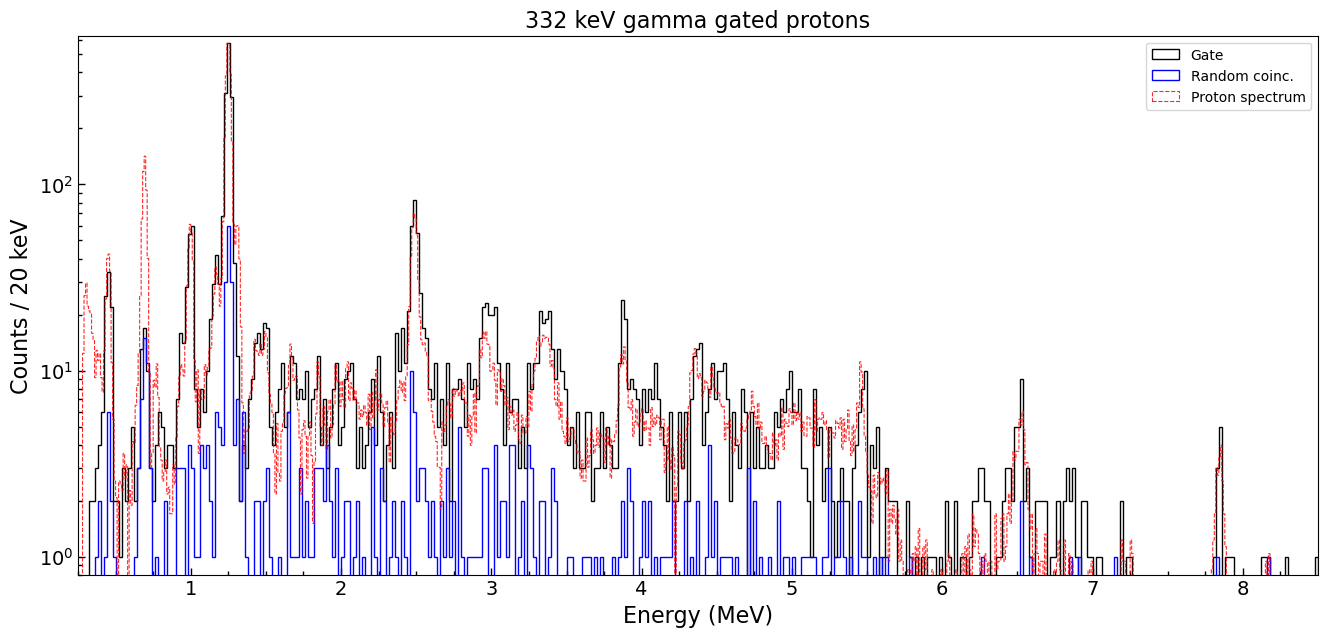

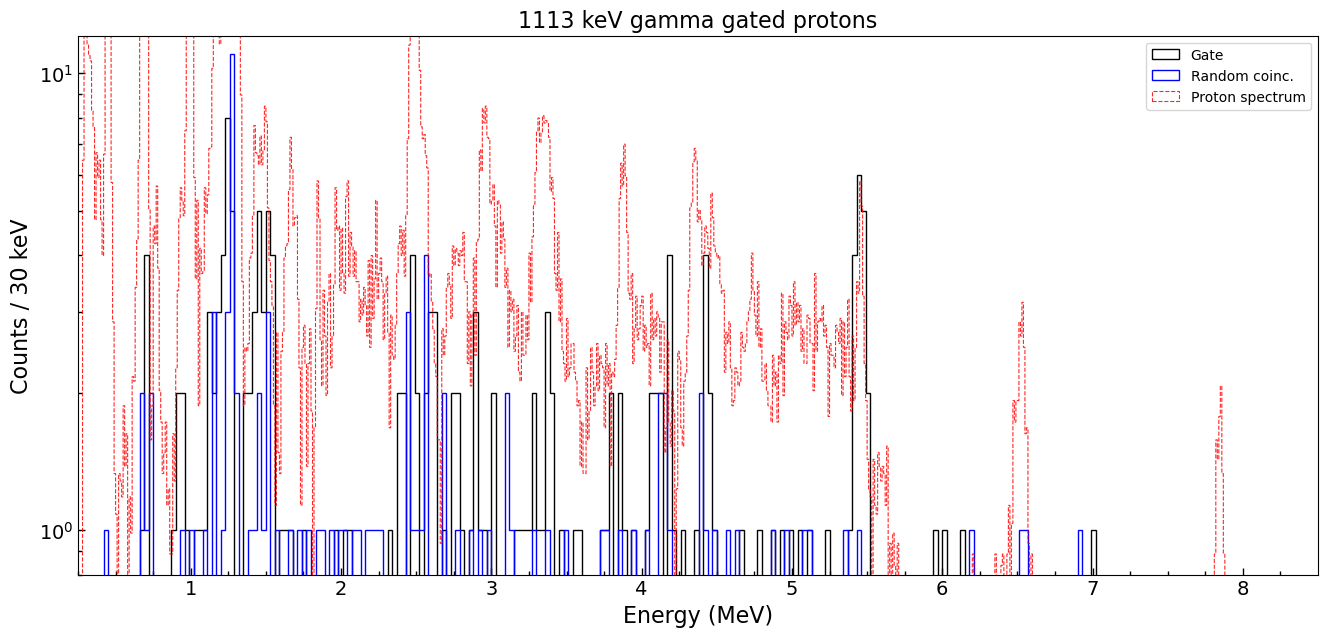

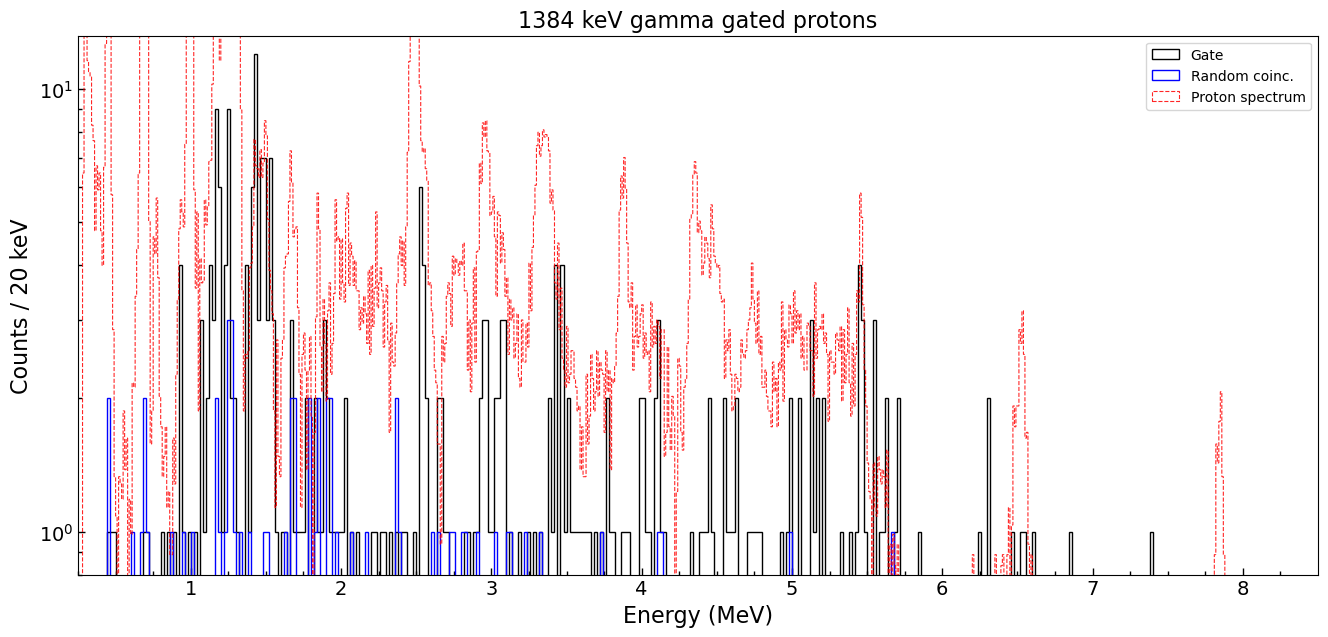

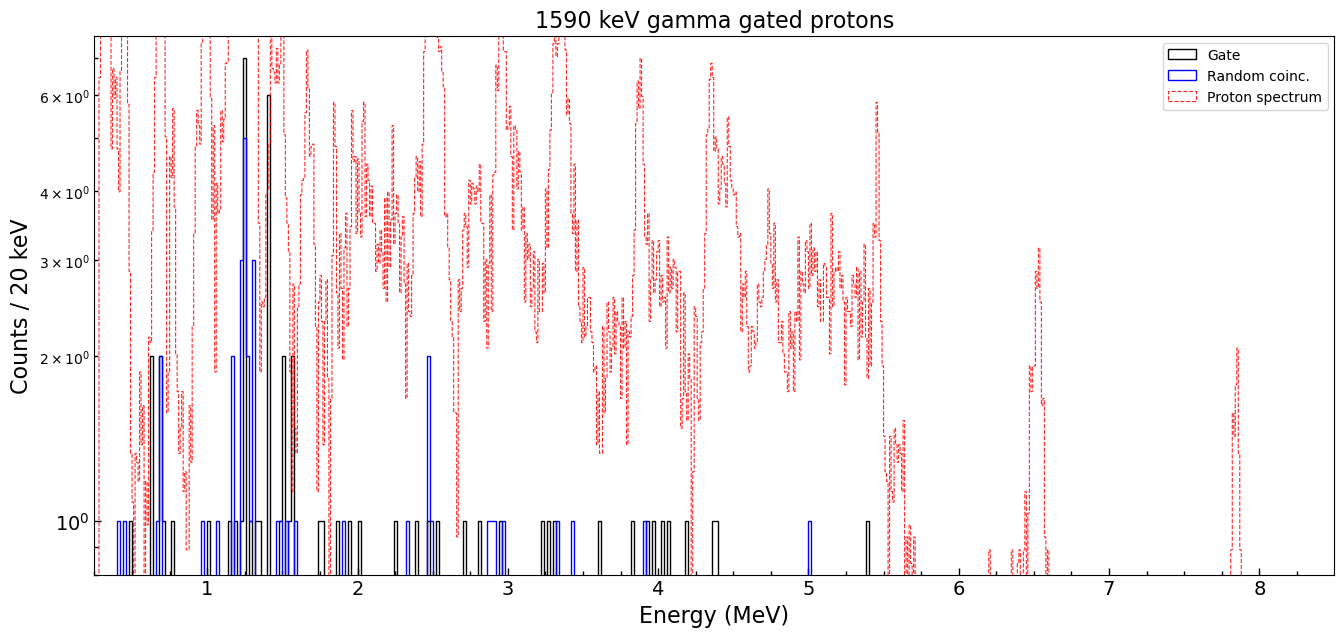

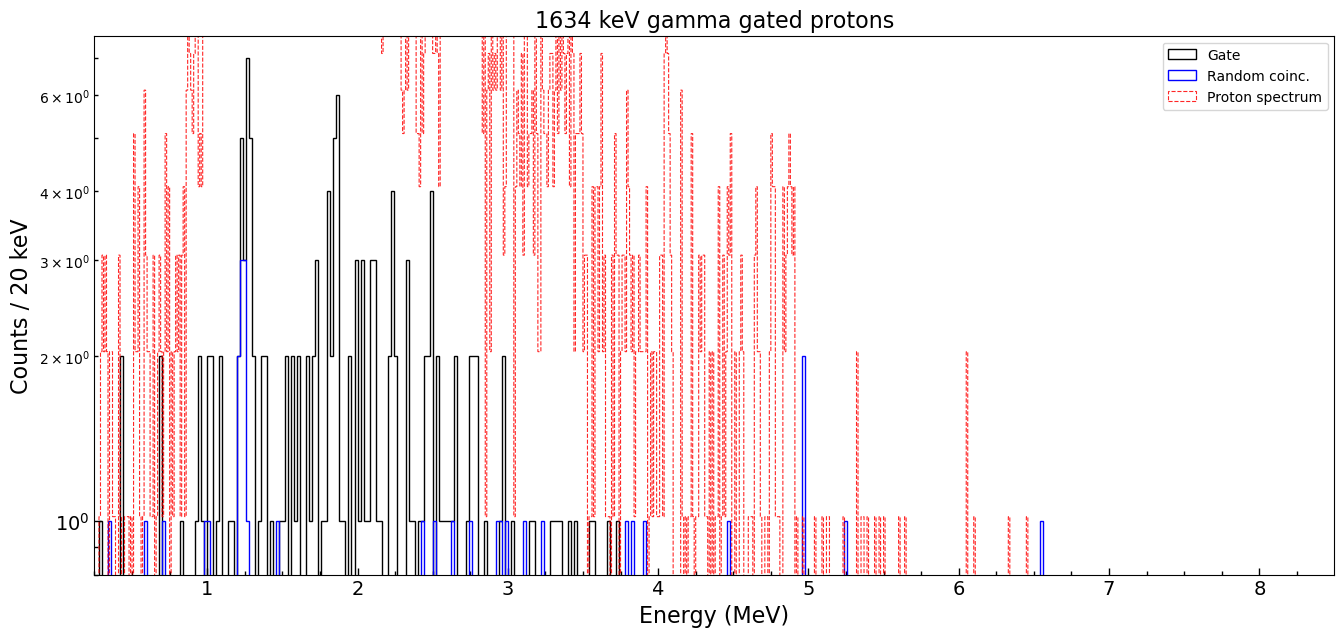

In [8]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [332,1113, 1384,1590, 1634]
binwidth = 0.02
scales = [None, 3*1e2, 3*1e2, 3*1e2, 50]
saves = [0.02, 0.03, 0.02, 0.02, 0.02]
for g,s, sa in zip(gates,scales, saves):
    
    if g==1634:
        overlay = E2p
    else:
        overlay = E
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = overlay,
        colors=['k', 'b', 'r'],
        labels=['Gate','Random coinc.'],
        over_binw = 0.01,
        bin_width=sa,
        scale=s,
        #xlim=(3,6),
        title=f"{g} keV gamma gated protons"
    )
    plt.show()


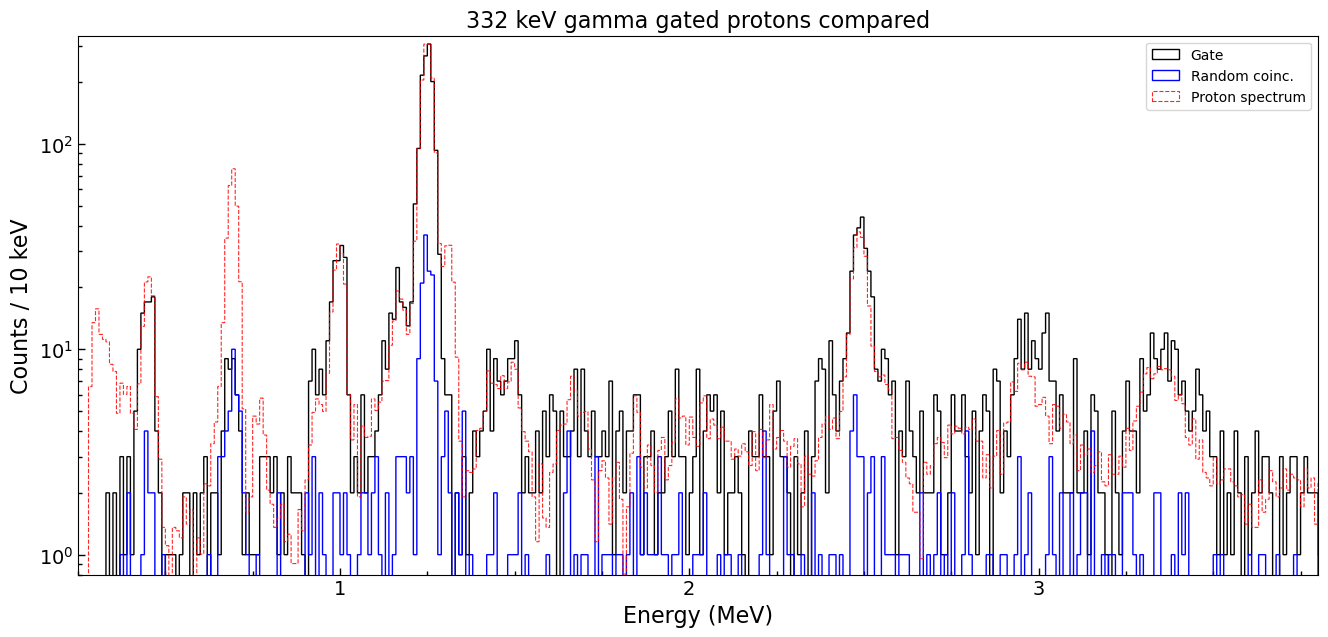

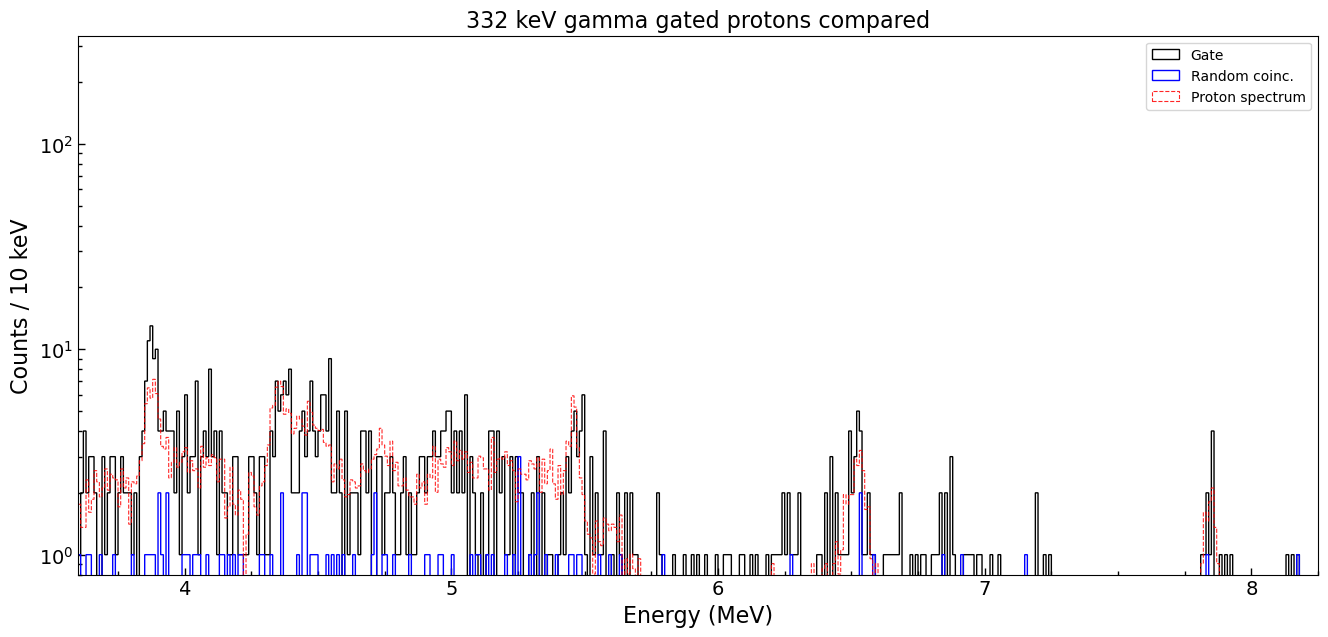

In [9]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [332, 332]
binwidth = 0.01
scales = [None, None]
xlims = [(0.25,3.8), (3.6,8.25)]
saves =[None, None]
for g,s,xls,sa in zip(gates,scales,xlims,saves):
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = E,
        colors=['k', 'b', 'r'],
        labels=['Gate','Random coinc.'],
        over_binw=0.01,
        bin_width=binwidth,
        scale=s,
        title=f"{g} keV gamma gated protons compared",
        xlim = xls,
        saveas=sa
    )


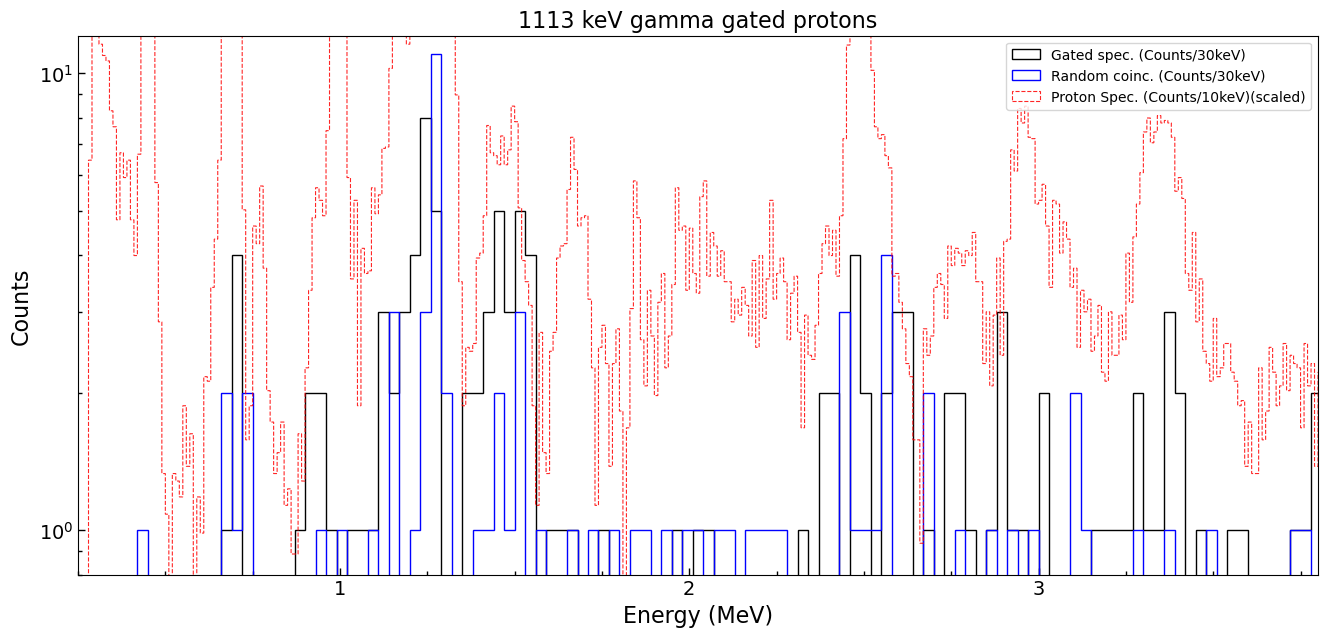

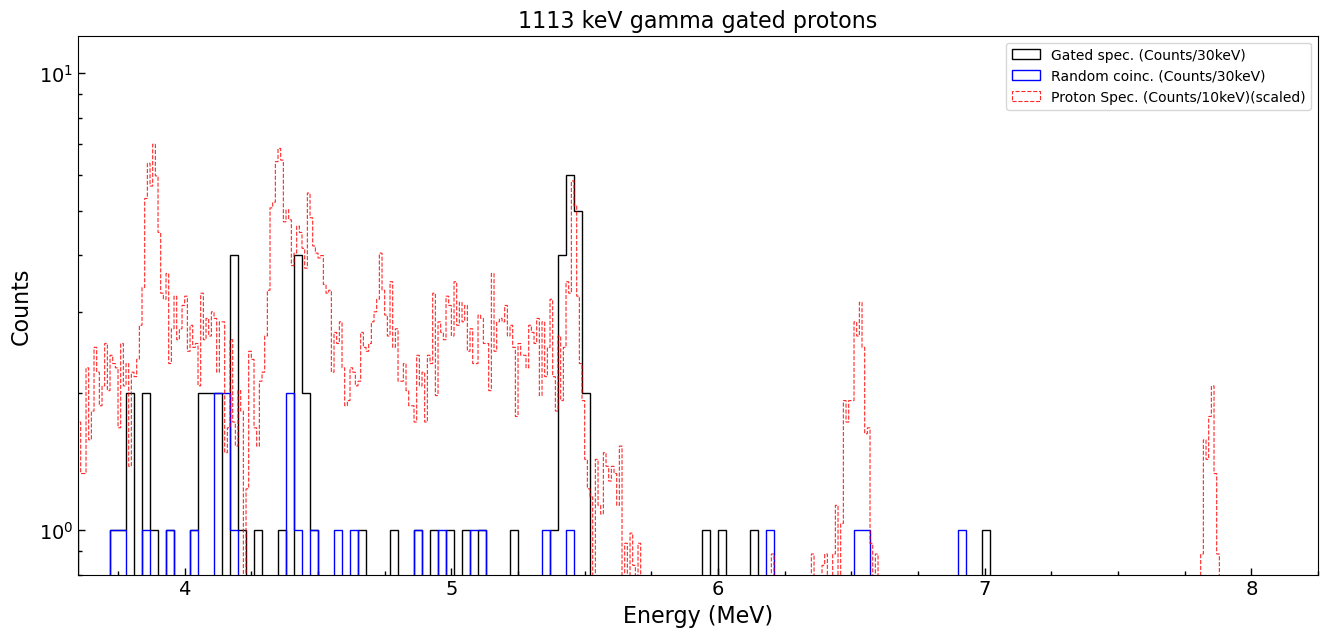

In [10]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [1113,1113]
binwidth = 0.03
scales = [3*1e2,3*1e2]
xlims = [(0.25,3.8), (3.6,8.25)]
saves =[None, None]
for g,s,xls,sa in zip(gates,scales,xlims,saves):
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = E,
        colors=['k', 'b', 'r'],
        labels=['Gated spec. (Counts/30keV)','Random coinc. (Counts/30keV)'],
        over_binw=0.01,
        bin_width=binwidth,
        scale=s,
        ylabel="Counts",
        title=f"{g} keV gamma gated protons",
        xlim = xls,
        saveas=sa,
        overlay_name="Proton Spec. (Counts/10keV)(scaled)"
    )


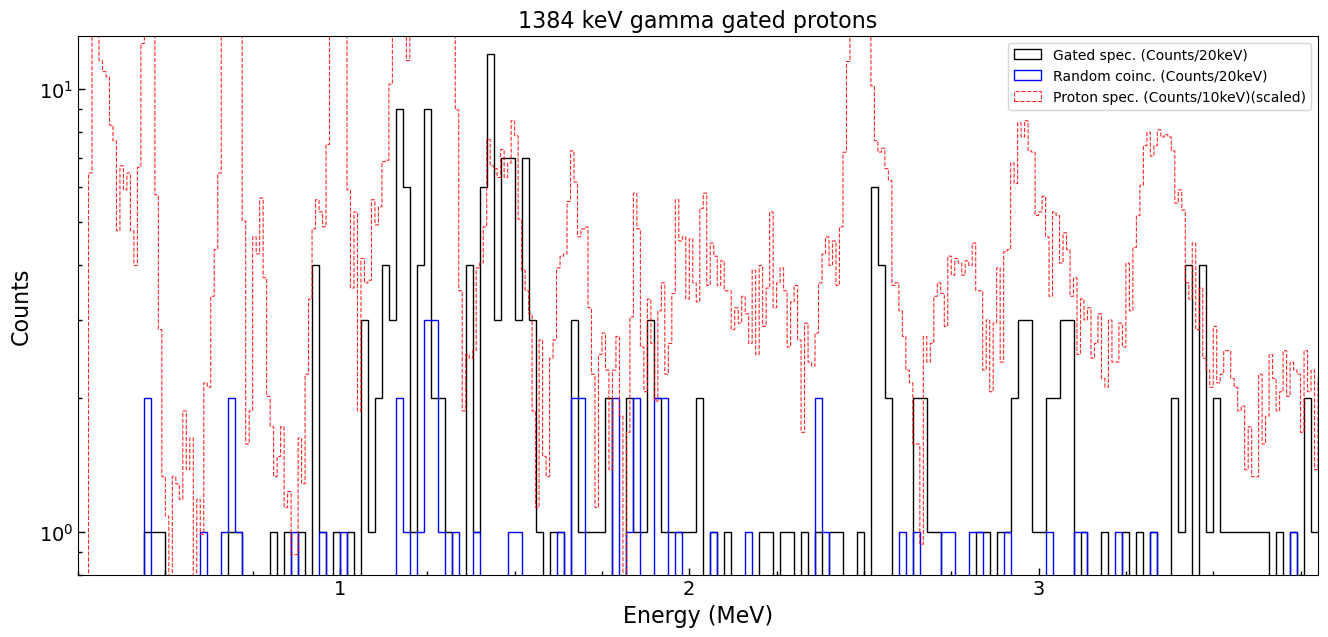

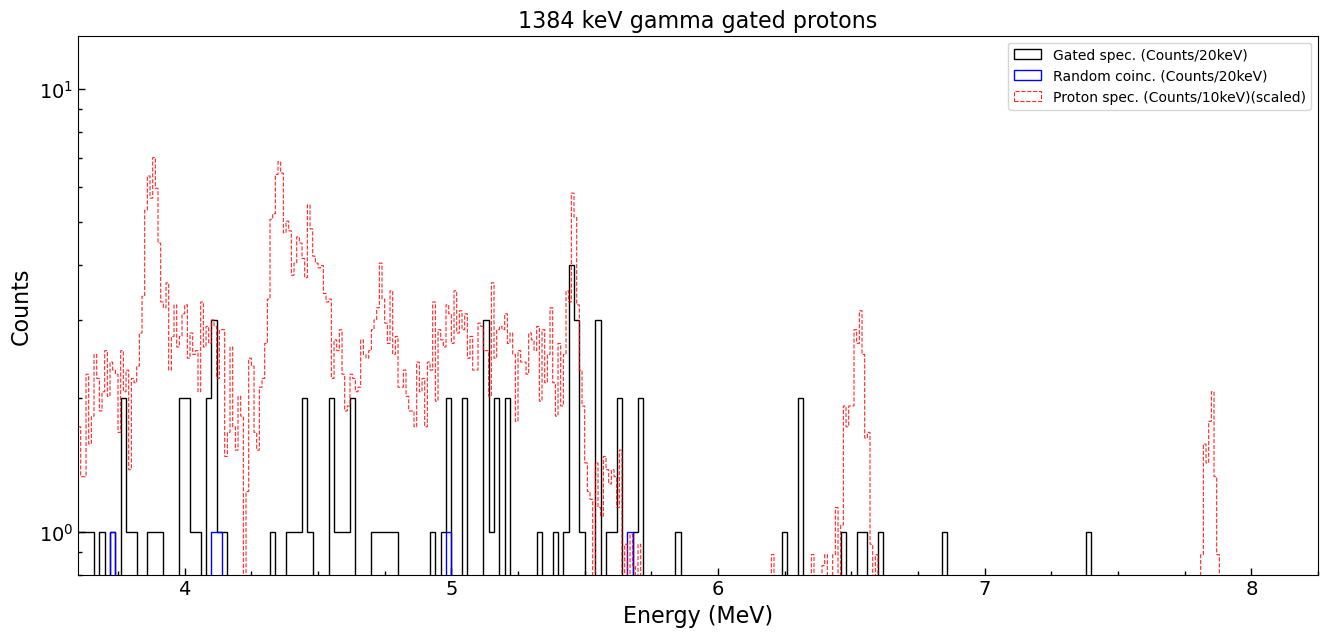

In [11]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [1384,1384]
binwidth = 0.02
scales = [3*1e2,3*1e2]
xlims = [(0.25,3.8), (3.6,8.25)]
saves =[None, None]
for g,s,xls,sa in zip(gates,scales,xlims,saves):
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = E,
        colors=['k', 'b', 'r'],
        labels=['Gated spec. (Counts/20keV)','Random coinc. (Counts/20keV)'],
        over_binw=0.01,
        bin_width=binwidth,
        ylabel="Counts",
        scale=s,
        title=f"{g} keV gamma gated protons",
        xlim = xls,
        saveas=sa,
        overlay_name = "Proton spec. (Counts/10keV)(scaled)"
    )

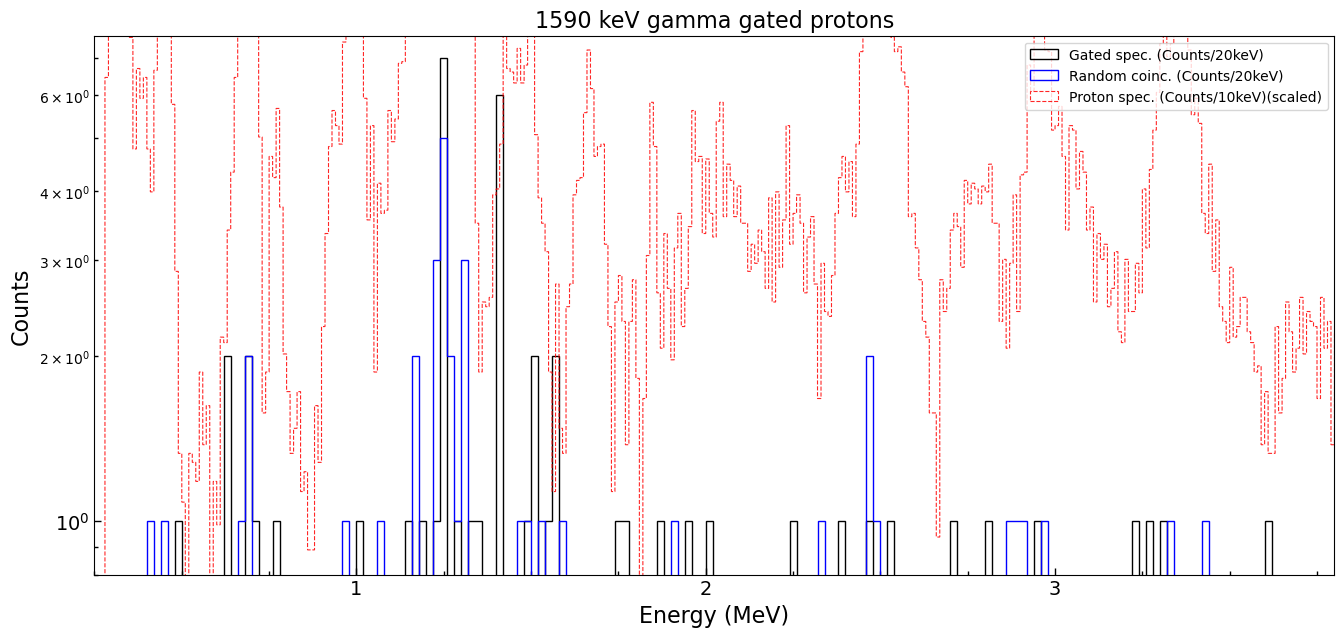

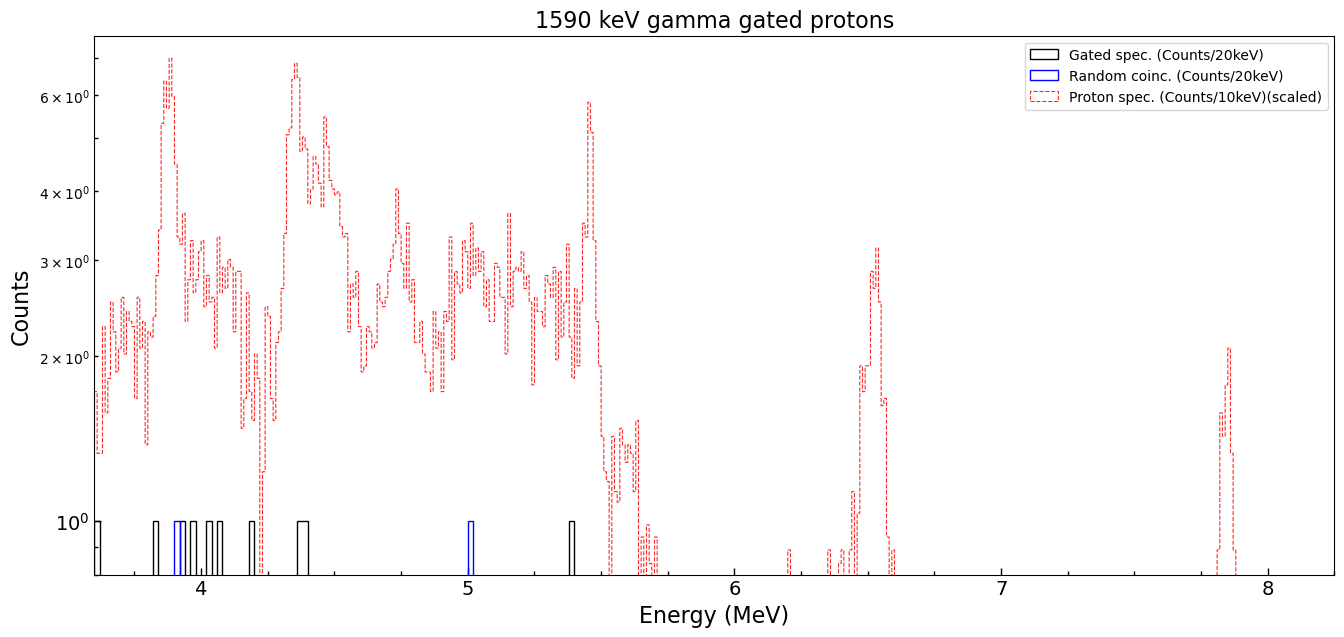

In [12]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [1590,1590]
binwidth = 0.02
scales = [3*1e2,3*1e2]
xlims = [(0.25,3.8), (3.6,8.25)]
saves =[None, None]
for g,s,xls,sa in zip(gates,scales,xlims,saves):
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = E,
        colors=['k', 'b', 'r'],
        labels=['Gated spec. (Counts/20keV)','Random coinc. (Counts/20keV)'],
        over_binw=0.01,
        bin_width=binwidth,
        ylabel="Counts",
        scale=s,
        title=f"{g} keV gamma gated protons",
        xlim = xls,
        saveas=sa,
        overlay_name = "Proton spec. (Counts/10keV)(scaled)"
    )

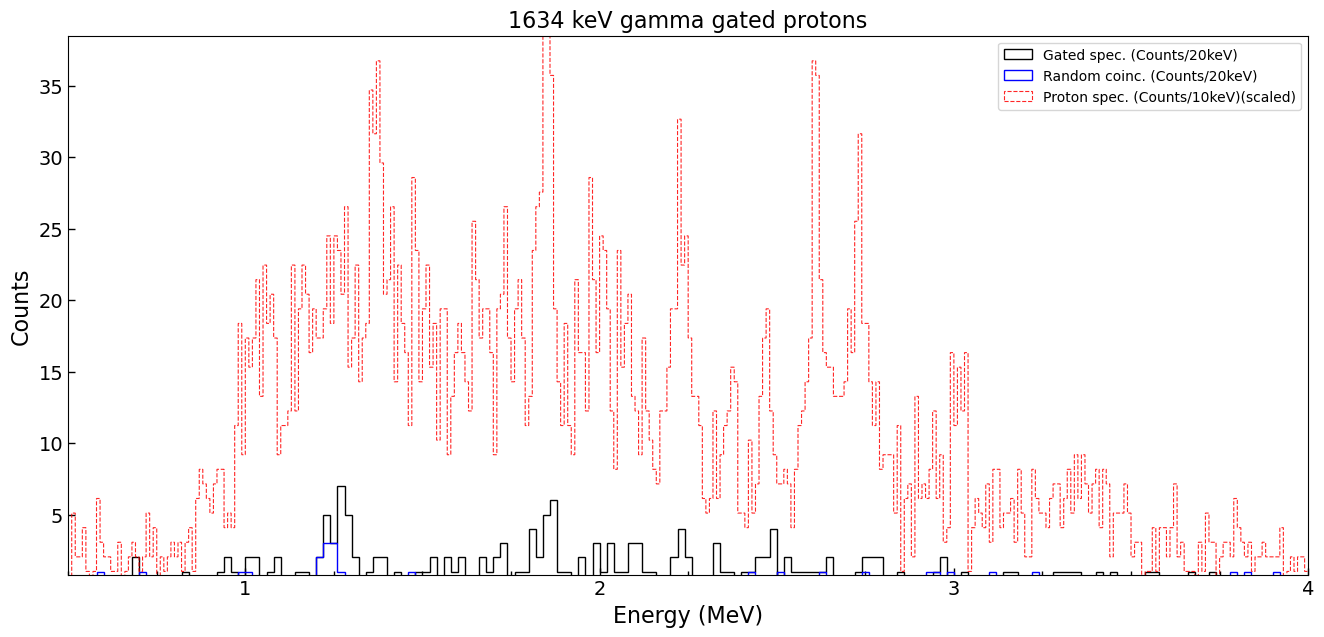

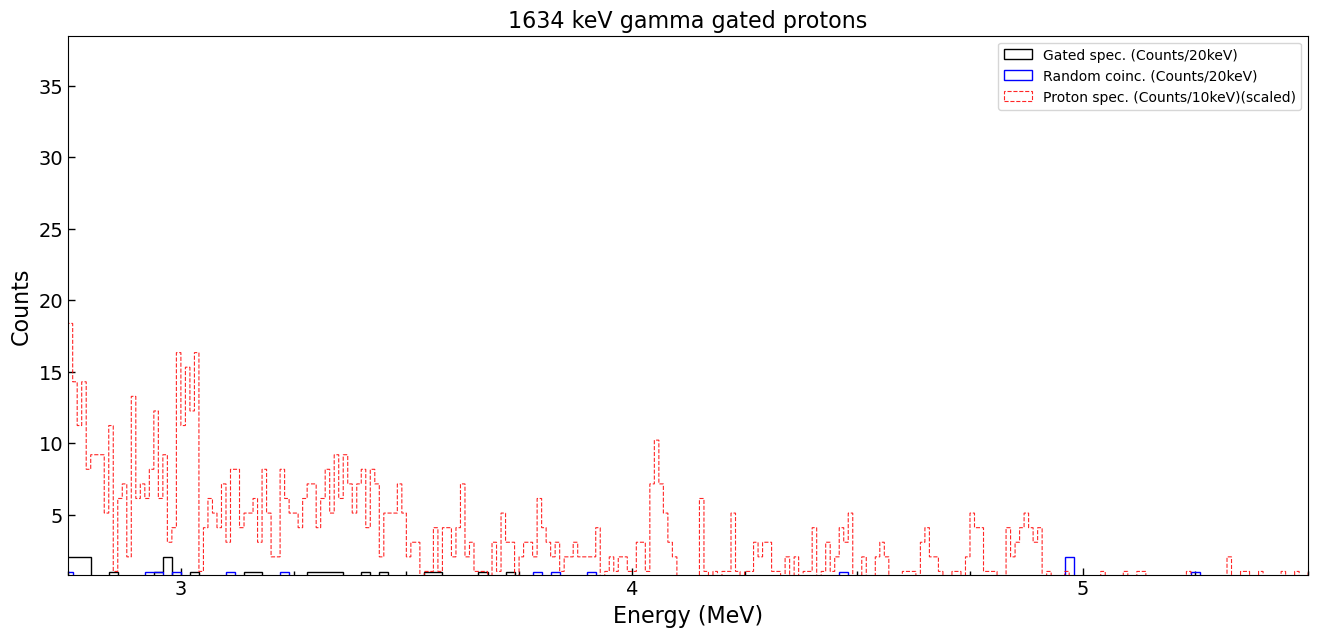

In [12]:

#gates = [332, 445, 735, 840, 950, 1070, 1113, 1384, 1590, 1634, 1716, 1745, 2497, 2830]
gates = [1634,1634]
binwidth = 0.02
scales = [50,50]
xlims = [(0.5,4), (2.75,5.5)]
saves =[None, None]
for g,s,xls,sa in zip(gates,scales,xlims,saves):
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["upper_bg"]],
        reference_overlay = E2p,
        colors=['k', 'b', 'r'],
        labels=['Gated spec. (Counts/20keV)','Random coinc. (Counts/20keV)'],
        over_binw=0.01,
        bin_width=binwidth,
        ylabel="Counts",
        scale=s,
        title=f"{g} keV gamma gated protons",
        xlim = xls,
        saveas=sa,
        overlay_name = "Proton spec. (Counts/10keV)(scaled)",
        maxy = 35,
        yscale='linear'
    )
